In [1]:
from collections import OrderedDict
import csv
import IPython.display as ipyd
import ipywidgets as ipyw
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import openpyxl as pyxl
import os
import string


def iter_rows(ws):
    '''Return the rows of an excel sheet as lists'''
    for row in ws.iter_rows():
        yield [cell.value for cell in row]

def subtractBaselineAndLog(array):
    '''Subtract the optical density due to the media itself and take the logarithm of the optical density
       so that a line can be fit to the growth curve to find the growth rate'''
    return np.log(array - .99*np.min(array))

def windowedLineFit(x,y,start,stop):
    '''Fit a line to a portion of some data stored in arrays'''
    m, b = np.polyfit(x[start:stop],y[start:stop],1)
    return m, b

def growthRateToDoublingTime(r):
    '''Formula for the time it takes an e. coli cell to divide once given the exponential growth rate'''
    return np.log(2)/r

def loadFits(file):
    '''
    Load the fitting parameters for a platereader experiment from a .csv file
    '''
    time_ranges = OrderedDict()
    growth_fits = OrderedDict()
    with open(file) as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        first_row = True
        for row in reader:
            if not first_row:
                time_ranges[row[0]] = (float(row[3]),float(row[4]))
                growth_fits[row[0]] = (float(row[1]),float(row[2]))
            first_row = False
    return time_ranges, growth_fits


class manualGrowthFitter(object):
    '''
    Handle manually fitting lines to the logarithm of the OD minus the OD at 0 population.
    '''
    
    
    def __init__(self, times, wells_dict, figure_size = (16,16), load_time_ranges=None,
                 load_growth_fits=None):
        self.times = times
        self.wells_dict = wells_dict
        self.figure_size = figure_size
        if load_time_ranges is None:
            self.time_ranges = OrderedDict()
            for key in self.wells_dict.keys():
                self.time_ranges[key] = (times[0], times[-1])
        else:
            self.time_ranges = load_time_ranges
        if load_growth_fits is None:
            self.growth_fits = OrderedDict()
            for key in self.wells_dict.keys():
                self.growth_fits[key] = windowedLineFit(self.times,
                                                        subtractBaselineAndLog(self.wells_dict[key]),
                                                        0,-1)
        else:
            self.growth_fits = load_growth_fits
        
        sorted_keys = list([key for key in wells_dict])
        sorted_keys.sort()
        self.well_select = ipyw.Dropdown(options=sorted_keys, description = 'well')
        self.time_slider = ipyw.FloatRangeSlider(value=[times[0],times[-1]], min=times[0],
                                               max=times[-1], step=times[1]-times[0],
                                               description='time (hours)',
                                               continuous_update=False)
        self.box=ipyw.VBox()
        self.box.children=[self.well_select, self.time_slider]
        self.updatePlots(self.well_select.value, self.time_slider.value)
        
        def onWellChange(well):
            old_t_value = self.time_slider.value
            self.time_slider.value = self.time_ranges[well]
            if old_t_value == self.time_slider.value:
                self.updatePlots(well, self.time_slider.value)
        
        def onTimeChange(times):
            well = self.well_select.value
            self.time_ranges[well]=times
            t_start = np.where(np.abs(self.times-times[0])<=(self.times[1]-self.times[0])/4)[0][0]
            t_end = np.where(np.abs(self.times-times[1])<=(self.times[1]-self.times[0])/4)[0][0]
            self.growth_fits[well]=windowedLineFit(self.times,subtractBaselineAndLog(self.wells_dict[well]),
                                                   t_start,t_end)
            self.updatePlots(well, times)
        
        ipyw.interactive(onWellChange, well=self.well_select)
        ipyw.interactive(onTimeChange, times=self.time_slider)


    def updatePlots(self, well, times):
        '''
        Update plots to display the data from the well and the best fit line for exponential growth
        '''
        fig = plt.figure(figsize=self.figure_size)
        subplot = fig.add_subplot(111)
        subplot.plot(self.times,subtractBaselineAndLog(self.wells_dict[well]),'*')
        t_start = np.where(np.abs(self.times-times[0])<=(self.times[1]-self.times[0])/2)[0][0]
        t_end = np.where(np.abs(self.times-times[1])<=(self.times[1]-self.times[0])/2)[0][0]
        print(t_start, t_end)
        fit_times = self.times[t_start:t_end]
        m = self.growth_fits[well][0]
        b = self.growth_fits[well][1]
        subplot.plot(fit_times,m*fit_times+b,'r')
        subplot.legend(['data', 'fit r= {:4.3f}'.format(m)])
        subplot.set_xlabel('time (hours)')
        subplot.set_ylabel('log(OD-baseline)')

0 36


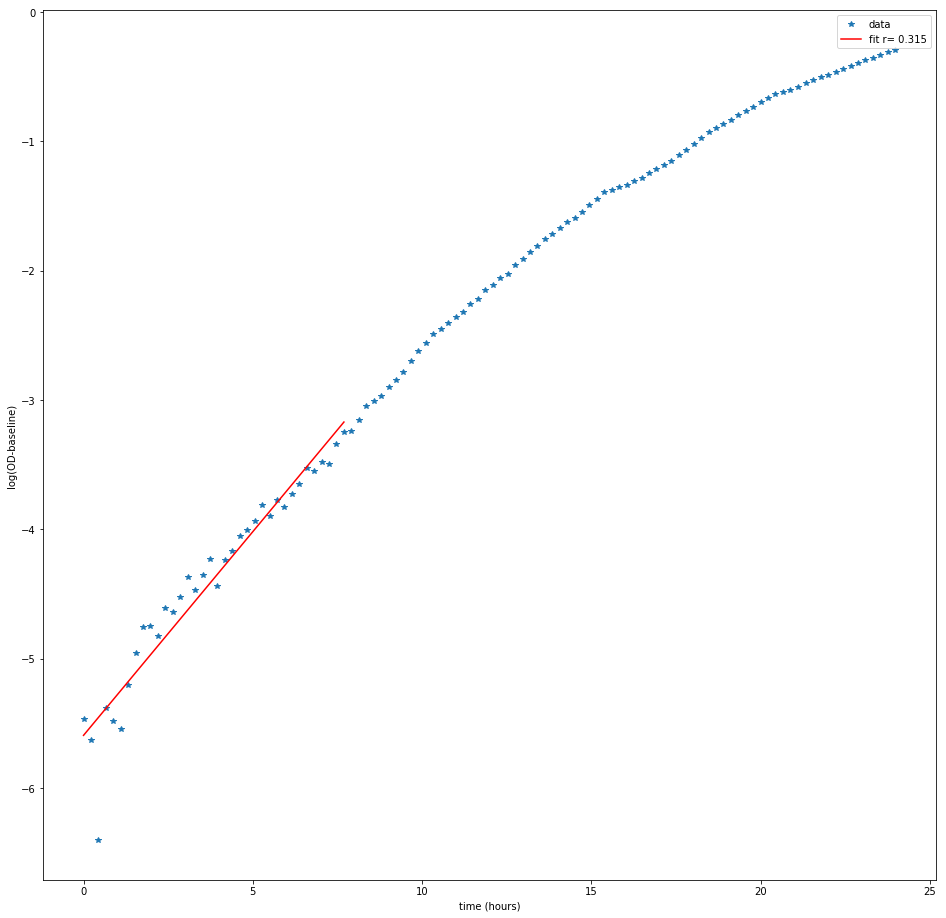

In [2]:
os.chdir('/home/kuhlmanlab/Documents/platereader_experiments/')
excel_filename = "MG1655 Chloramphenicol 5 Feb averages.xlsx"
excel_workbook = pyxl.load_workbook(excel_filename)
excel_sheet = excel_workbook[excel_workbook.get_sheet_names()[0]]

data = list(iter_rows(excel_sheet))
times = np.array([float(value.strip('s'))/3600 #divide by 3600 to convert seconds to hours
                  for value in data[0]]) 
temperatures = np.array([float(value.strip(' \xc2\xb0\C')) #to get numbers out need to remove the units
                         for value in data[1]])
wells = [np.array([value for value in data[i]]) for i in range(2,26)]

wells_dict = OrderedDict()
j=0
for letter in ['A', 'B', 'C', 'D']:
    for i in range(1,7):
        wells_dict[letter+str(i)]=wells[j]
        j=j+1

growth_results_filename = excel_filename.strip('.xslx') + ' results.csv'
try:
    load_time_ranges, load_growth_fits = loadFits(growth_results_filename)
except FileNotFoundError:
    load_time_ranges = None
    load_growth_fits = None

GROAR = manualGrowthFitter(times, wells_dict, (16,16), load_time_ranges, load_growth_fits)
ipyd.display(GROAR.box)

In [3]:
with open(growth_results_filename,'w') as gf_writes:
    gf_writes.write('well,growth_rate,intercept,time_fit_start,time_fit end\n')
    for key, value in GROAR.growth_fits.items():
        gf_writes.write(key + ',' + str(value[0]) + ',' + str(value[1]) + ','
                        + str(GROAR.time_ranges[key][0]) + ',' + str(GROAR.time_ranges[key][1]) + '\n')
print(gf_writes.closed)

True
